<a href="https://colab.research.google.com/github/KhouloudSD/facial_emotions_recognition/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Required packages

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os

In [3]:
from keras.datasets import cifar10
from keras import metrics
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras import metrics
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD
import pickle
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf

# Load the Images from Disk

In [4]:
!unzip -q /content/drive/MyDrive/FER_dataset.zip

In [5]:
train_dir = "/content/train/"
test_dir = "/content/test/"

# Data Exploration

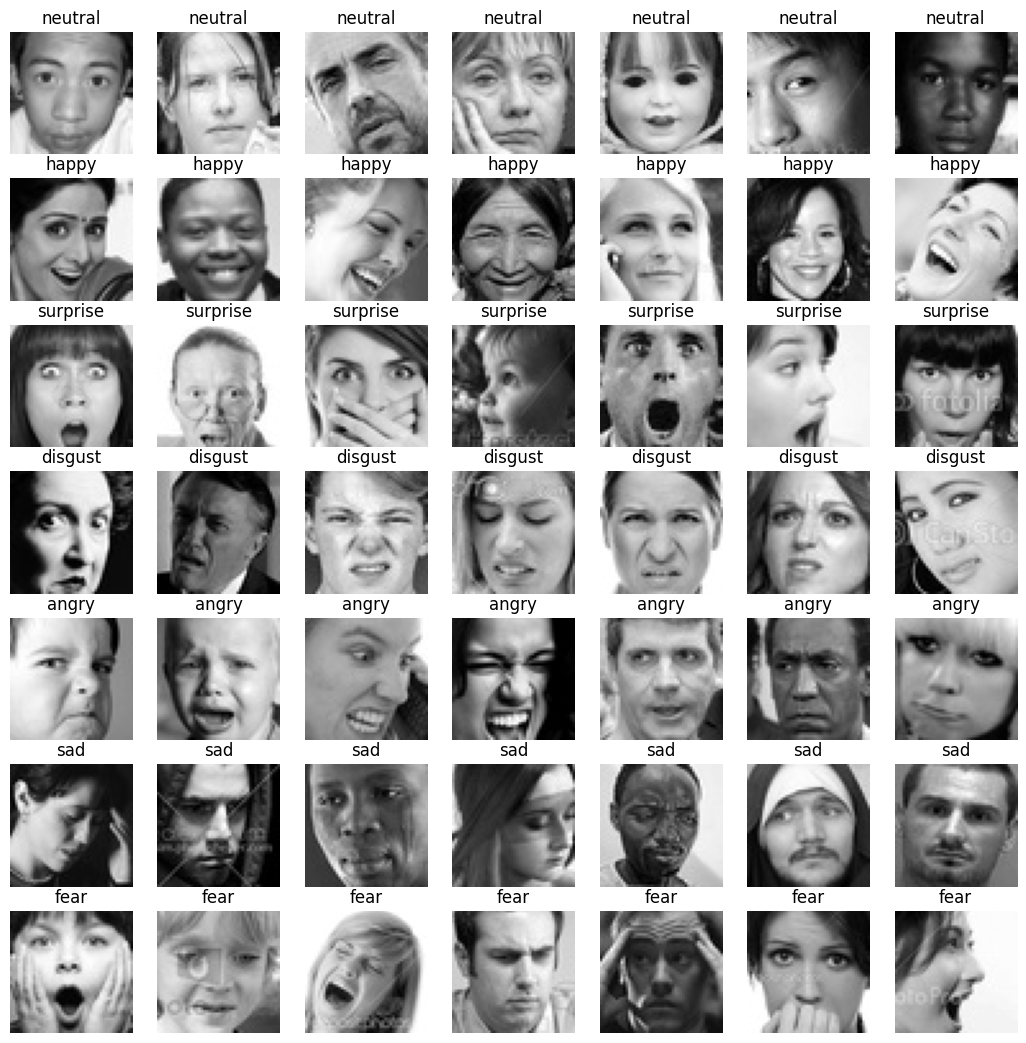

In [6]:
def visualize_examples(directory, num_examples=7):
    emotions = os.listdir(directory)
    num_rows = len(emotions)
    fig, axs = plt.subplots(num_rows, num_examples, figsize=(13, 13))
    for i, emotion in enumerate(emotions):
        emotion_dir = os.path.join(directory, emotion)
        image_files = os.listdir(emotion_dir)[:num_examples]

        for j, image_file in enumerate(image_files):
            image_path = os.path.join(emotion_dir, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            # Display images in separate lines
            axs[i, j].imshow(image, cmap='gray')
            axs[i, j].set_title(emotion)
            axs[i, j].axis('off')
    plt.show()
visualize_examples(train_dir)

In [7]:
row, col = 48, 48
classes = 7
def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       neutral  happy  surprise  disgust  angry   sad  fear
train     4965   7215      3171      436   3995  4830  4097
      neutral  happy  surprise  disgust  angry   sad  fear
test     1233   1774       831      111    958  1247  1024


**PLot of number of images in train set**


<Axes: >

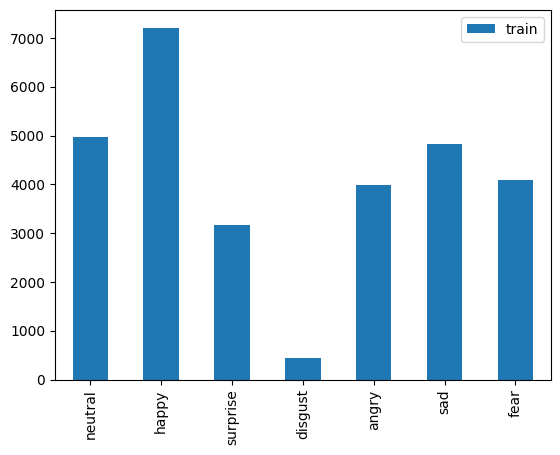

In [8]:
train_count.transpose().plot(kind='bar')

**PLot of number of images in test set**

<Axes: >

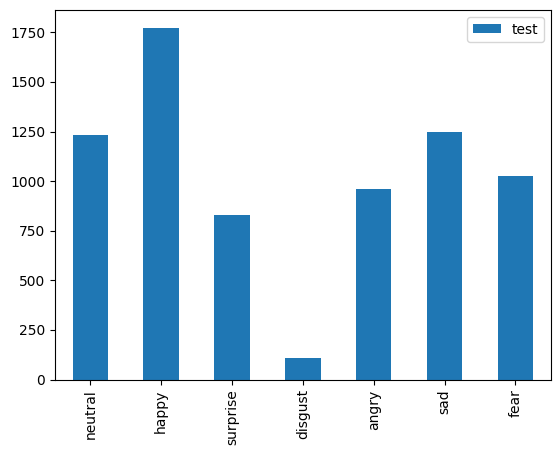

In [9]:
test_count.transpose().plot(kind='bar')

#  Set up an ImageDataGenerator and a data loader for the test dataset

In [10]:
images_generator = ImageDataGenerator(rescale=1.0/255.0)
data_loader = images_generator.flow_from_directory(test_dir, target_size=(224, 224), color_mode='rgb', batch_size=32)

Found 7178 images belonging to 7 classes.


In [11]:
data_loader.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [12]:
x, y = data_loader.next()

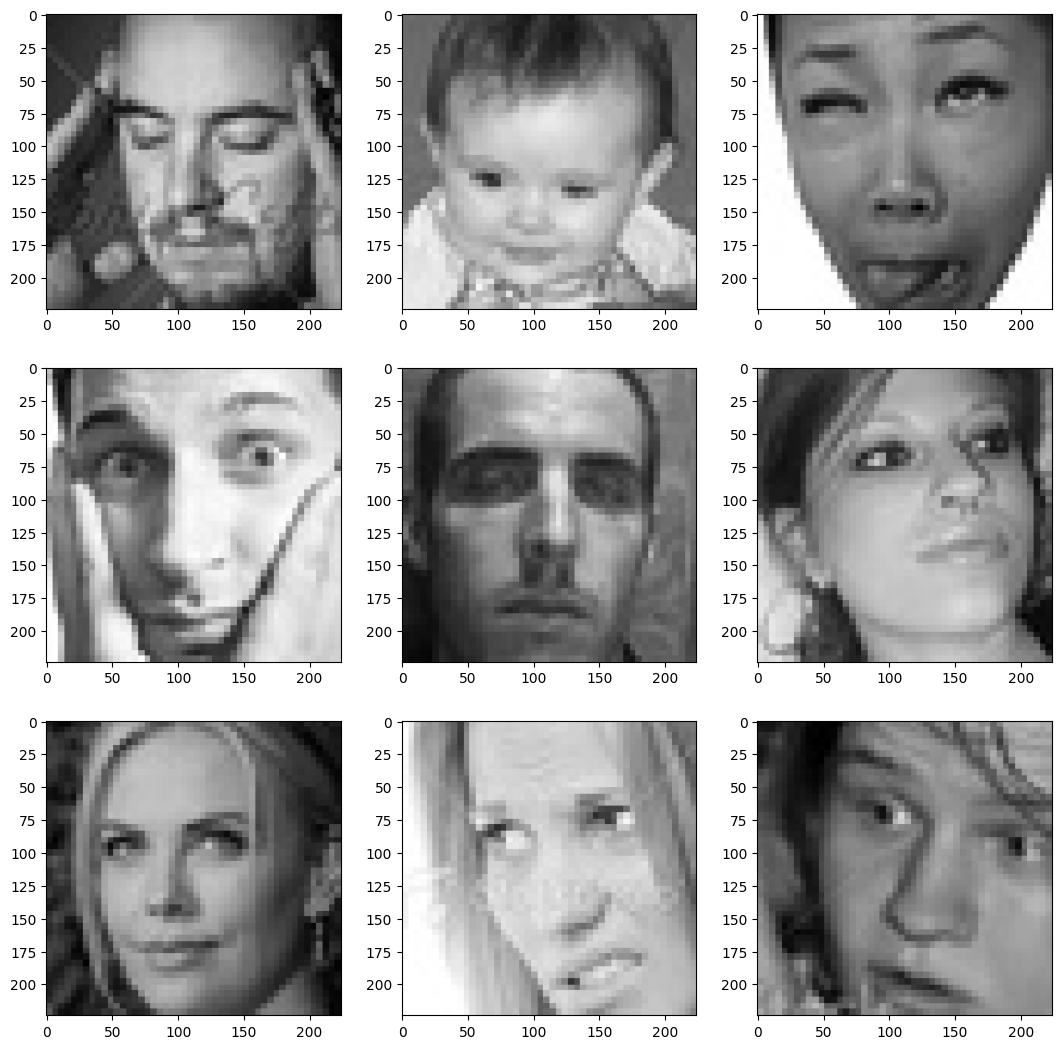

In [13]:
def plot_images(images):
  fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(13,13))
  for i, ax in enumerate(axs.flatten()):
    if i < len(images):
        ax.imshow(images[i])
    else:
        ax.remove()
  plt.show()
plot_images(x)

The Images are grayscale but in RGB mode which means the value of a pixel is duplicate for each color channel. Converting the images to grayscale (48, 48, 3) -> (48, 48) will speed up processing and learning.


# Grayscale pixels frequency Histogram

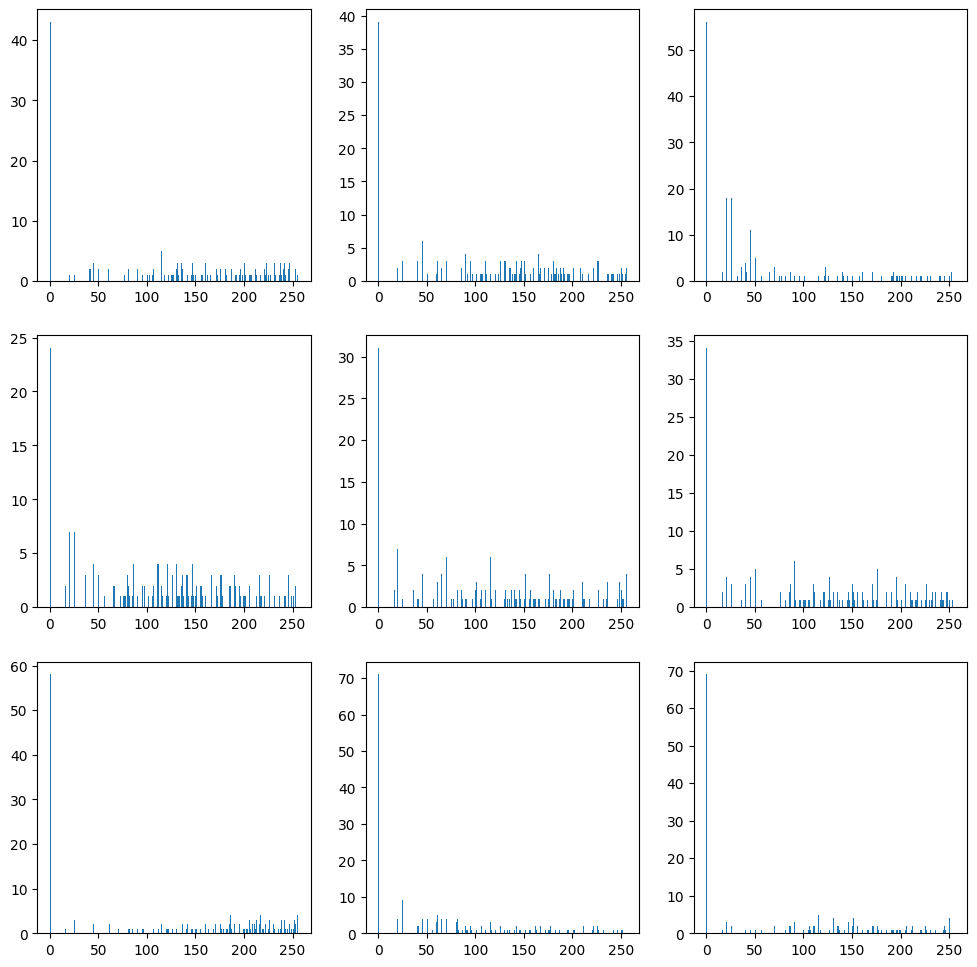

In [14]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12,12))
images = [x[i] for i in range(9)]
for i, ax in enumerate(axs.flatten()):
    if i < len(images):
        histr = cv2.calcHist([images[i]*255],[0],None,[256],[0,256])
        ax.hist(histr, bins=256, range=[0,256])
    else:
        ax.remove()
plt.show()

# **CNN - Model Creation**

This Sequential model defines a Convolutional Neural Network (CNN) for facial expression classification. It starts with a convolutional layer of 32 filters and a 3x3 kernel, followed by batch normalization and max-pooling. The network deepens with increasing filters, incorporating dropout for regularization. The final layers consist of flattened, dense, and output layers for classification. Batch normalization and dropout enhance stability and prevent overfitting.

In [15]:
model = Sequential()

# Add a convolutional layer with 32 filters, 3x3 kernel size, relu activation function and a batch normalization layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# Add a dense layer with 1024 neurons and relu activation function
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# Add a dense layer with 7 neurons (one for each class) and softmax activation function
model.add(Dense(7, activation='softmax'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 44, 44, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 64)        0         
 D)                                                              
                                                        

In [17]:
model.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

# **data augmentation**

In this code section, we are setting up data generators for training and validation. The train_datagen and validation_datagen are instances of the ImageDataGenerator class from Keras, which allows us to perform real-time data augmentation during training.

For the training generator (train_generator), we apply various augmentation techniques, including width and height shifting, horizontal flipping, and rescaling. The subset="training" parameter ensures that it generates batches only from the training set.

Similarly, the validation generator (validation_generator) applies rescaling without augmentation and generates batches from the validation set (subset="validation").

The plot_images function visualizes sample images from the validation set, and the binarization function performs binarization on the images, which is not strictly a data augmentation technique but rather a preprocessing step.

In summary, this code sets up data generators with augmentation for training and rescaling for validation, providing an efficient way to handle large datasets and improve the model's generalization by introducing variations in the training data.

In [18]:
validation_datagen = ImageDataGenerator(rescale = 1.0/255.0
                                        , validation_split = 0.2 )

train_datagen = ImageDataGenerator(width_shift_range = 0.1
                                   , height_shift_range = 0.1
                                   , horizontal_flip = True
                                   , rescale = 1.0/255.0 ,
                                   validation_split = 0.2 )

In [19]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (48, 48),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training" )
 # Resizes all images to 48x48 pixels   # Number of images per batch    # Converts the images to grayscale    # Classifies the images into
 #7 categories  # Uses the training subset of the data

validation_generator = validation_datagen.flow_from_directory(directory = test_dir,
                                                              target_size = (48, 48),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation" )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [20]:
z, t = train_generator.next()

In [21]:
x, y = validation_generator.next()

In [22]:
def plot_images(images, preprocessing_func=None):
  fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
  if preprocessing_func is not None :
      images = [preprocessing_func(images[i]) for i in range(9)]
  for i, ax in enumerate(axs.flatten()):
    if i < len(images):
        ax.imshow(images[i])
    else:
        ax.remove()
  plt.show()

In [ ]:
plot_images(z)

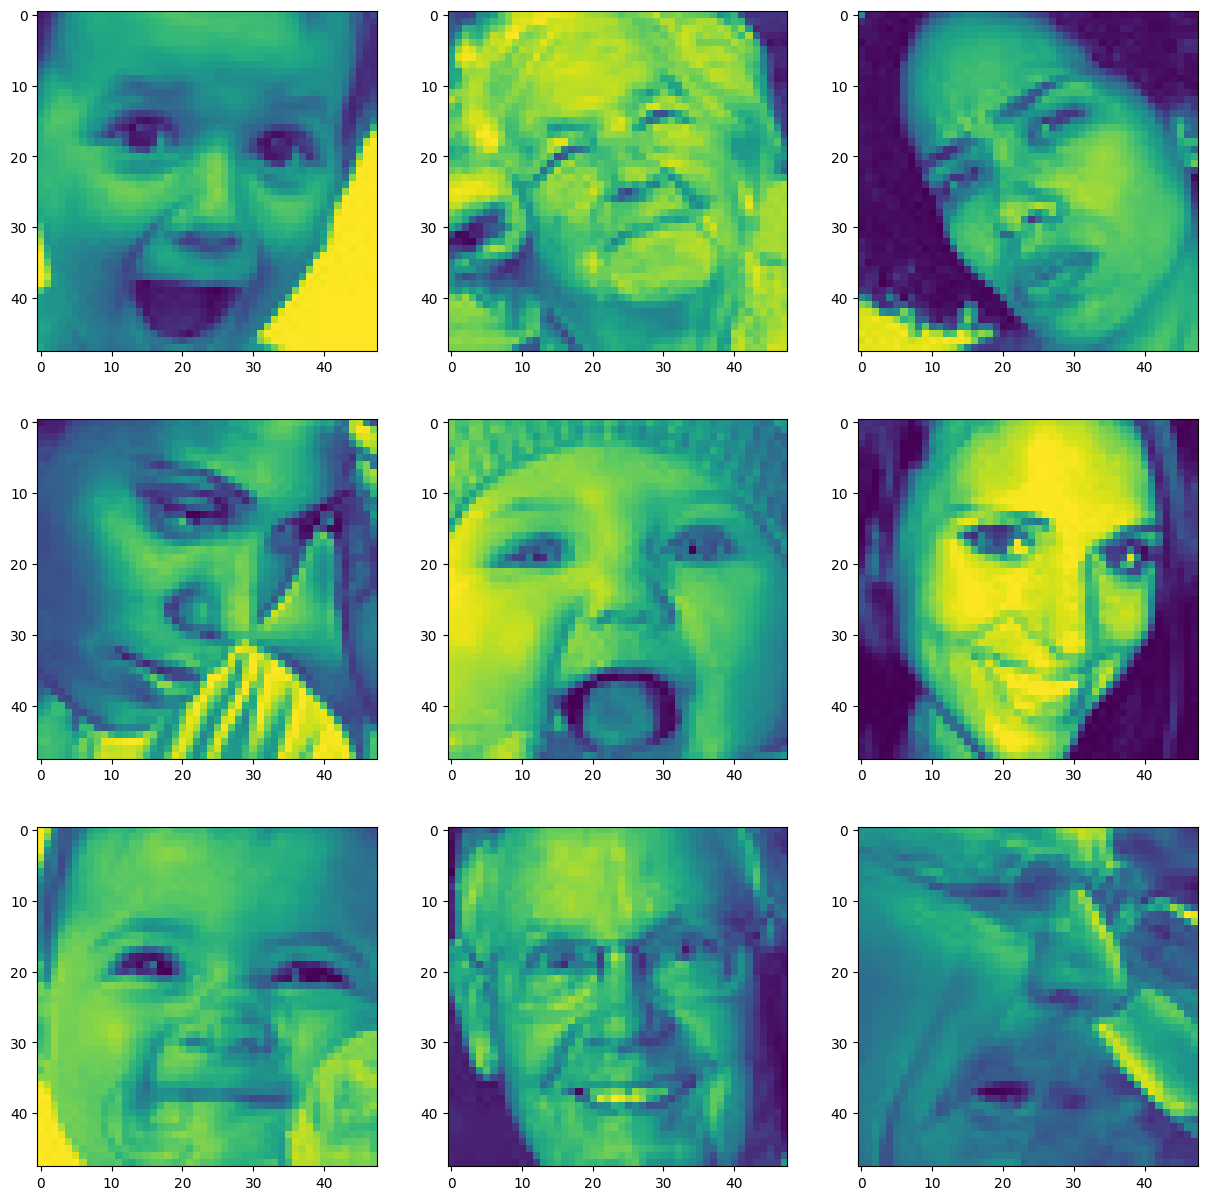

In [24]:
plot_images(x)

# **Model Training**

In [25]:
# Train the model with the callback
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/50
359/359 [==============================] - 41s 67ms/step - loss: 2.8005 - accuracy: 0.1899 - val_loss: 2.0625 - val_accuracy: 0.2018
Epoch 2/50
359/359 [==============================] - 26s 73ms/step - loss: 2.4301 - accuracy: 0.2371 - val_loss: 1.7029 - val_accuracy: 0.3534
Epoch 3/50
359/359 [==============================] - 24s 68ms/step - loss: 2.2231 - accuracy: 0.2665 - val_loss: 1.5814 - val_accuracy: 0.4050
Epoch 4/50
359/359 [==============================] - 26s 73ms/step - loss: 2.0777 - accuracy: 0.2989 - val_loss: 1.6444 - val_accuracy: 0.3855
Epoch 5/50
359/359 [==============================] - 24s 67ms/step - loss: 1.9707 - accuracy: 0.3230 - val_loss: 1.5109 - val_accuracy: 0.4358
Epoch 6/50
359/359 [==============================] - 26s 73ms/step - loss: 1.8778 - accuracy: 0.3436 - val_loss: 1.4437 - val_accuracy: 0.4511
Epoch 7/50
359/359 [==============================] - 24s 66ms/step - loss: 1.7962 - accuracy: 0.3619 - val_loss: 1.4149 - val_accuracy:

# **Validation and Optimization**

23/23 [==============================] - 1s 34ms/step - loss: 0.9799 - accuracy: 0.6334
Validation Accuracy: 63.34%


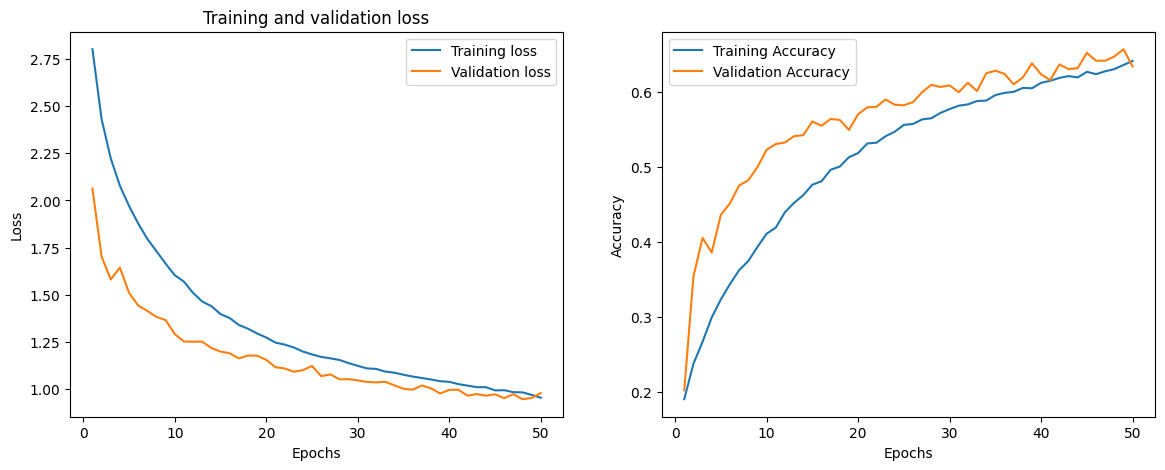

In [29]:
# Plot the train and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1,2,2)
# Evaluate the model on the validation set
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")
# Plot training history
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



# **Confusion Matrix**

23/23 [==============================] - 1s 28ms/step


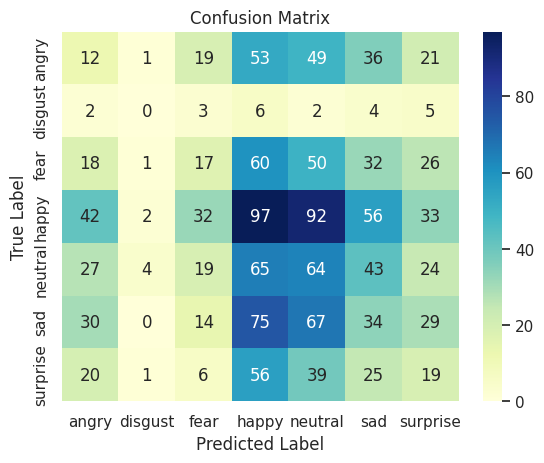

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the true labels and predicted labels for the validation set
validation_labels = validation_generator.classes
validation_pred_probs = model.predict(validation_generator)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(train_generator.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()